<a href="https://colab.research.google.com/github/anoopsanka/retinal_oct/blob/main/notebooks/OCT_simclr_label_smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/anoopsanka/retinal_oct

Cloning into 'retinal_oct'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 537 (delta 51), reused 58 (delta 21), pack-reused 434
Receiving objects: 100% (537/537), 255.07 MiB | 29.00 MiB/s, done.
Resolving deltas: 100% (292/292), done.


In [2]:
%%capture
# needed to use rotate....
!pip install -U tensorflow_addons

In [3]:
%cd retinal_oct

/content/retinal_oct


In [4]:
import tensorflow_datasets as tfds
from importlib.util import find_spec
if find_spec("core") is None:
    import sys
    sys.path.append('..')
    
from core.datasets import RetinaDataset

In [5]:
ds_train, ds_train_info = tfds.load('RetinaDataset', split='train', shuffle_files=False, as_supervised=True, with_info=True)
ds_test                 = tfds.load('RetinaDataset', split='test', shuffle_files=False, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/retina_dataset/1.0.0.incomplete4S0QTQ/retina_dataset-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/retina_dataset/1.0.0.incomplete4S0QTQ/retina_dataset-test.tfrecord


Dataset retina_dataset downloaded and prepared to /root/tensorflow_datasets/retina_dataset/1.0.0. Subsequent calls will reuse this data.


In [6]:
import os
import random
import numpy as np
import tensorflow as tf

# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

In [7]:
%%capture
!pip install -U wandb
!pip install envyaml

# Pull Sample Weights from Wandb
https://wandb.ai/hisunnytang/OCT-keras-SimCLR


97 % contrastive accuracy & ~ 90 % supervised accuracy
- https://wandb.ai/hisunnytang/OCT-keras-SimCLR/runs/1ipksk06/overview?workspace=user-hisunnytang

In [8]:
from core.models.simclr_model import Pretrained_SimCLR_Model

In [9]:
import wandb
api = wandb.Api()
run = api.run("hisunnytang/OCT-keras-SimCLR/1ipksk06")
run.file("weights.108-0.97.hdf5").download()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<_io.TextIOWrapper name='./weights.108-0.97.hdf5' mode='r' encoding='UTF-8'>

In [10]:
config = run.config

In [11]:
config

{'IMG_SIZE': 128,
 'batch_size': 128,
 'epochs': 120,
 'ft_proj_selector': 0,
 'hidden_norm': True,
 'learning_rate': 0.01,
 'learning_rate_scaling': 'linear',
 'num_classes': 4,
 'num_examples': 83489,
 'num_proj_layers': 3,
 'proj_head_mode': 'nonlinear',
 'proj_out_dim': 128,
 'resnet_depth': 18,
 'resnet_se_ratio': 0,
 'resnet_sk_ratio': 0,
 'resnet_width_multiplier': 1,
 'temperature': 1,
 'use_blur': True,
 'warmup_epochs': 10}

In [232]:
model_loadweights = Pretrained_SimCLR_Model()
input_shape_base   = (None, config["IMG_SIZE"], config["IMG_SIZE"], 3)
input_shape_simclr = (None, config["IMG_SIZE"], config["IMG_SIZE"], 6)
model_loadweights.base_model.build(input_shape_base)
model_loadweights.build(input_shape_simclr)
model_loadweights.summary()
model_loadweights.load_weights('weights.108-0.97.hdf5')

Model: "pretrained__sim_clr__model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_1 (Resnet)            multiple                  11190464  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_1 (Projectio multiple                  594304    
Total params: 11,786,830
Trainable params: 11,774,788
Non-trainable params: 12,042
_________________________________________________________________


In [13]:
from core.datasets.data_augmentation import train_classification_aug

def train_data_aug(img, lb):
  xs = []
  for _ in range(2):
    xs.append(train_classification_aug(img, lb, img_size = config["IMG_SIZE"])[0])
  img = tf.concat(xs, -1)
  return img, tf.one_hot(lb, 4)

def val_data_aug(img, lb):
  xs = []
  for _ in range(2):
    xs.append(train_classification_aug(img, lb, img_size = config["IMG_SIZE"])[0])
  img = tf.concat(xs, -1)
  return img, tf.one_hot(lb, 4)

def resize_only(img, lb):
  img = tf.image.resize(img, (128,128))
  img = tf.cast(img, tf.float32) / 255.
  return img, tf.one_hot(lb, 4)

# When `training = False` / making prediction
## Inputs
- X:
  - shape: `[bsz, IMG_SIZE, IMG_SIZE, 3]`

## outputs
- proj:
  - shape: `[bsz, 128]`
- logits:
  - shape: `[bsz, NUM_CLASSES]`

In [272]:

def resize_only(img, lb, img_size=128):
  img = tf.image.resize(img, (128,128))
  img = tf.cast(img, tf.float32) / 255.
  return img, tf.one_hot(lb, 4)

def extract_embedding(model, 
                      dataset, 
                      save_dir = '/content/drive/MyDrive/fourthbrain-ai'):
  """Extract the layers to np array"""
  all_train_proj = []
  all_train_logits = []
  all_train_labels = []

  for X, y in dataset.map(resize_only).batch(128):
    proj, logits = model.call(X, training=False)
    all_train_proj.append(proj.numpy())
    all_train_logits.append(logits.numpy())
    all_train_labels.append(y.numpy())

  all_train_proj_   = np.vstack(all_train_proj)
  all_train_logits_ = np.vstack(all_train_logits)
  all_train_labels_ = np.vstack(all_train_labels)

  np.save( os.path.join(save_dir, "train_proj.npy"), all_train_proj_)
  np.save( os.path.join(save_dir, 'train_logits.npy'), all_train_logits_)
  np.save( os.path.join(save_dir, 'train_labels.npy'), all_train_labels_)

In [273]:
extract_embedding(model_loadweights, ds_train)

In [233]:
# # get the projections/ logits/ and labels
# all_train_proj = []
# all_train_logits = []
# all_train_labels = []


# def resize_only(img, lb):
#   img = tf.image.resize(img, (128,128))
#   img = tf.cast(img, tf.float32) / 255.
#   return img, tf.one_hot(lb, 4)

# t = 0
# for X, y in ds_train.map(resize_only).batch(128):
#   proj, logits = model_loadweights.call(X, training=False)
#   all_train_proj.append(proj.numpy())
#   all_train_logits.append(logits.numpy())
#   all_train_labels.append(y.numpy())

# all_train_proj_   = np.vstack(all_train_proj)
# all_train_logits_ = np.vstack(all_train_logits)
# all_train_labels_ = np.vstack(all_train_labels)

# np.save('/content/drive/MyDrive/fourthbrain-ai/train_proj.npy', all_train_proj_)
# np.save('/content/drive/MyDrive/fourthbrain-ai/train_logits.npy', all_train_logits_)
# np.save('/content/drive/MyDrive/fourthbrain-ai/train_labels.npy', all_train_labels_)

In [274]:
X, y = next(iter(ds_train.map(resize_only).batch(128)))
proj, logits = model_loadweights.call(X, training=False)
sum(logits.numpy().argmax(axis=-1) == y.numpy().argmax(axis=-1)) / 128

0.765625

In [275]:
# get the last conv layer

# extract embedding

x = tf.keras.Input((128,128,3))
final_conv = model_loadweights.layers[0](x)
embedding_globalAvg = tf.keras.layers.GlobalAveragePooling2D()(final_conv)
model_global_embedding = tf.keras.Model(x, embedding_globalAvg)
all_train_resnet_embed = []

t = 0
for X, y in ds_train.map(resize_only).batch(128):
  embedding_resnet = model_global_embedding.call(X, training=False)
  all_train_resnet_embed.append(embedding_resnet.numpy())

all_train_resnet_embed_   = np.vstack(all_train_resnet_embed)

np.save('/content/drive/MyDrive/fourthbrain-ai/train_resnet_proj.npy', all_train_resnet_embed_)

In [298]:
X, y  = next(iter(ds_train.map(resize_only).batch(128))) 

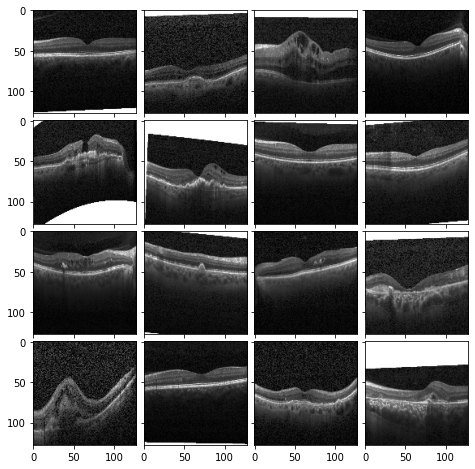

In [299]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, X[:16]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

# [Label Propagation for Deep Semi-supervised Learning](https://arxiv.org/pdf/1904.04717.pdf)
- transductive learning with kNN graph


## Difference between LabelSpreading/ LabelPropagation
[Getting Started With Semi-Supervised Learning](https://blog.dataiku.com/finding-a-balance-with-semi-supervised-learning#:~:text=Label%20propagation%20computes%20a%20similarity,be%20more%20robust%20to%20noise.)
> A good place to jumpstart semi-supervised learning efforts is scikit-learn’s semi-supervised module, which implements two flavors of semi-supervised methods that perform label inference on unlabeled data using a graph-based approach. Label propagation computes a similarity matrix between samples and uses a KNN-based approach to propagate samples, while label spreading takes a similar approach but adds a regularization to be more robust to noise. We restricted our experiment to label spreading for optimal performance.

> The underlying (supervised) model can also be used to directly perform the pseudo-labeling, which is also known as self-training. Our findings are supported by an experiment on textual data using the AGNews dataset.

# Outline of the Idea
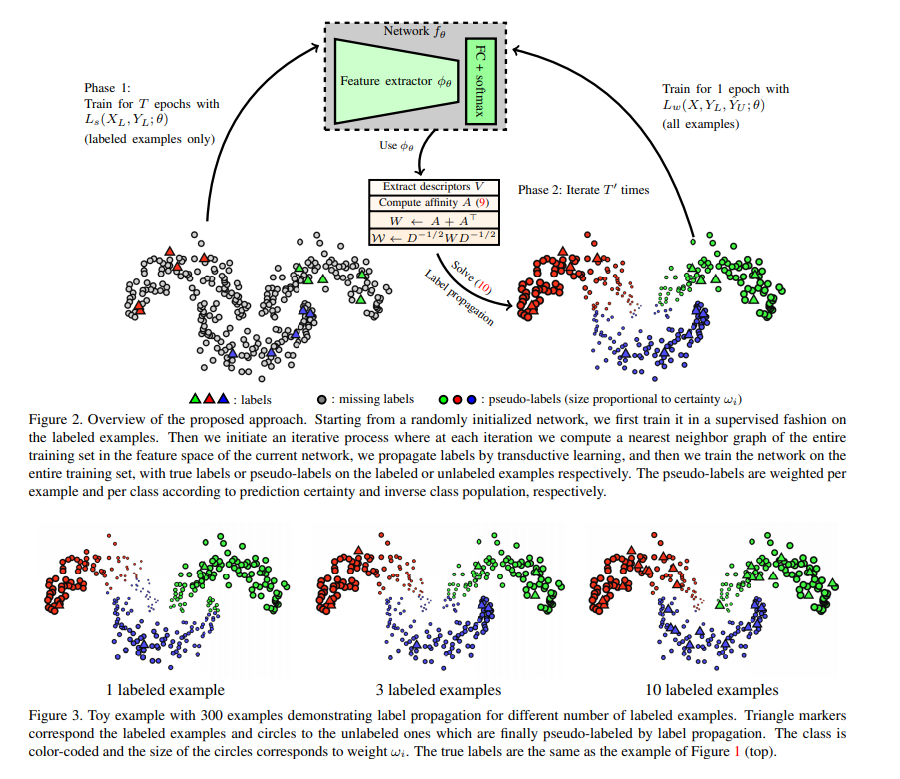

In [276]:
import numpy as np
from sklearn.semi_supervised import LabelSpreading
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap

In [277]:
all_train_proj   = np.load('/content/drive/MyDrive/fourthbrain-ai/train_proj.npy')
all_train_logits = np.load('/content/drive/MyDrive/fourthbrain-ai/train_logits.npy')
all_train_labels = np.load('/content/drive/MyDrive/fourthbrain-ai/train_labels.npy')
all_train_resnet_embed   = np.load('/content/drive/MyDrive/fourthbrain-ai/train_resnet_proj.npy')
all_train_proj_normed = all_train_proj / ((all_train_proj**2.0).sum(axis=-1, keepdims=True))**0.5

In [446]:
def embedding_dimension_reduction(embedding, 
                                  labels, 
                                  reduced_dimension = 8, 
                                  method = 'UMAP',
                                  metric = 'cosine', 
                                  pairplot=True, 
                                  baseline_regression = True):

  if method == 'UMAP':
    reducer           = umap.UMAP(n_components= reduced_dimension, metric=metric, n_neighbors= 50)
    reduced_embedding = reducer.fit_transform(embedding)
  elif method == 'PCA':
    reduced_embedding = PCA(n_components= reduced_dimension).fit_transform(embedding)

  if pairplot:
    df = pd.DataFrame()
    df[f'{method}1'] = reduced_embedding[:,0]
    df[f'{method}2'] = reduced_embedding[:,1]
    df[f'{method}3'] = reduced_embedding[:,2]
    df[f'{method}4'] = reduced_embedding[:,3]
    df[f'{method}5'] = reduced_embedding[:,4]
    df['class'] = labels
    sns.pairplot(df.sample(968), hue='class', palette='tab10', corner=True,)
  
  if baseline_regression:
    clf   = LogisticRegression( penalty='l2', max_iter=1000, class_weight='balanced').fit(reduced_embedding, labels)
    ypred = clf.predict(reduced_embedding)

    print(classification_report(labels, ypred))
    label_names_list = ds_train_info.features['label'].names
    plot_confusion_matrix(clf, 
                          reduced_embedding, 
                          labels, 
                          normalize='true', 
                          display_labels=label_names_list, 
                          cmap='inferno')

  return reduced_embedding

# Extract the embedding
- with PCA/ UMAP
- with projection head/ projection head normalizezd/ resnet_layer

## Pairplot
- shows the local clustering of labels (if there are any)

## Regression
- baseline proxy of the linear seperability of a logistic regression

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     26318
           1       0.32      0.52      0.39      8616
           2       0.69      0.74      0.72     11350
           3       0.94      0.79      0.86     37205

    accuracy                           0.76     83489
   macro avg       0.69      0.71      0.69     83489
weighted avg       0.80      0.76      0.77     83489



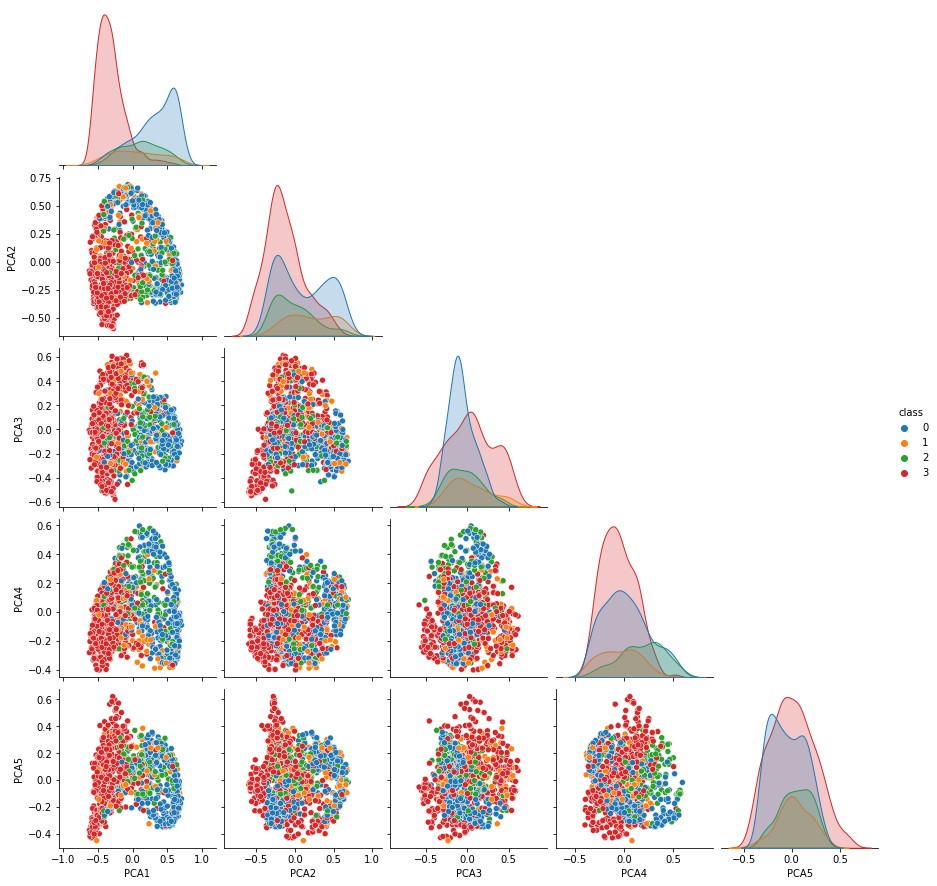

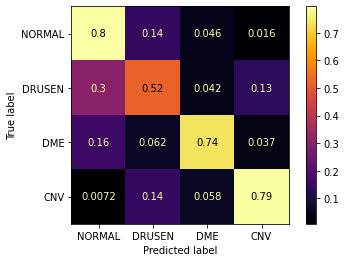

In [397]:
proj_normed_PCA = embedding_dimension_reduction(all_train_proj_normed, 
                                                all_train_labels.argmax(-1), 
                                                method='PCA', 
                                                metric='cosine')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.79      0.79      0.79     26318
           1       0.32      0.52      0.40      8616
           2       0.69      0.65      0.67     11350
           3       0.95      0.82      0.88     37205

    accuracy                           0.76     83489
   macro avg       0.69      0.70      0.68     83489
weighted avg       0.80      0.76      0.77     83489



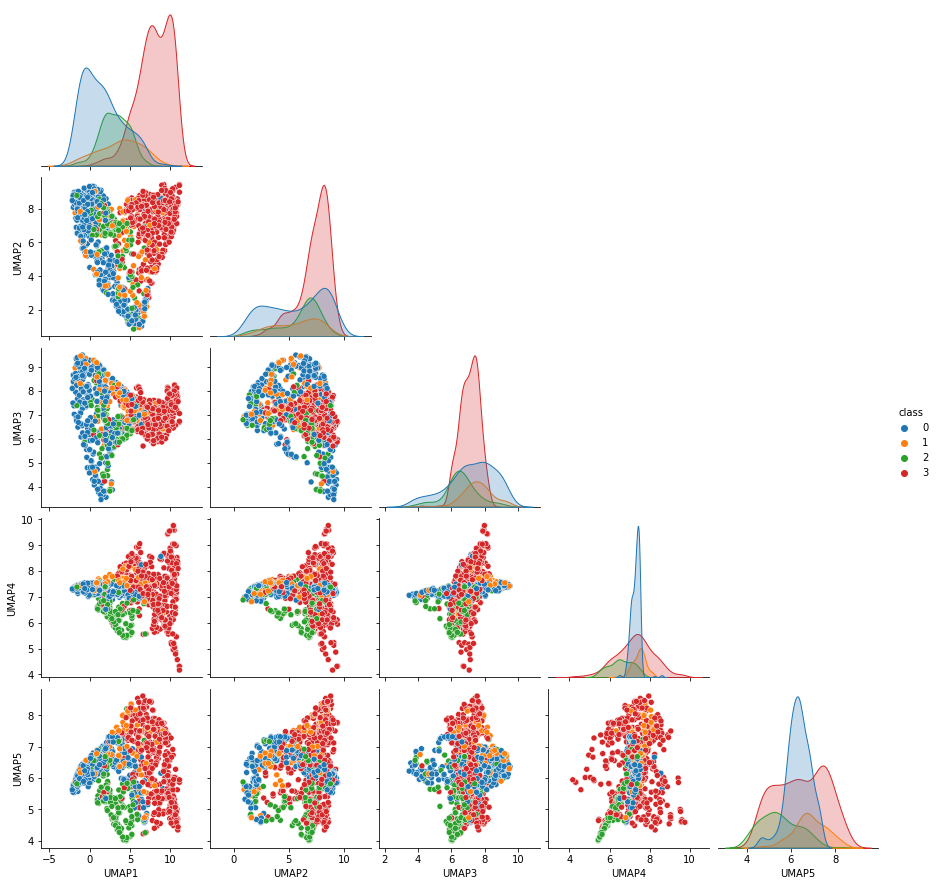

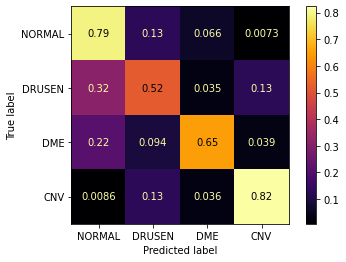

In [398]:
proj_normed_UMAP = embedding_dimension_reduction(all_train_proj_normed, 
                                                 all_train_labels.argmax(-1), 
                                                 method='UMAP',
                                                 metric='cosine')

## Resnet layer

              precision    recall  f1-score   support

           0       0.84      0.82      0.83     26318
           1       0.35      0.55      0.43      8616
           2       0.72      0.77      0.74     11350
           3       0.94      0.82      0.88     37205

    accuracy                           0.78     83489
   macro avg       0.71      0.74      0.72     83489
weighted avg       0.82      0.78      0.80     83489



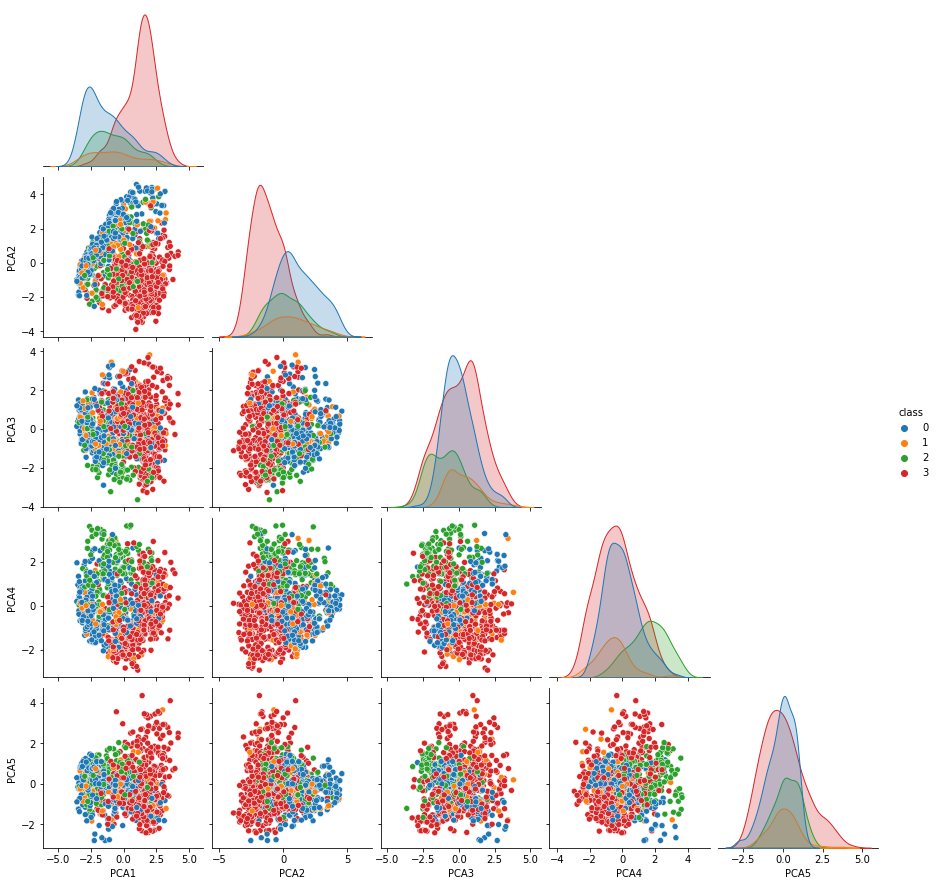

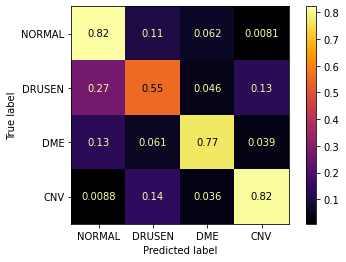

In [399]:
resnet_proj_PCA = embedding_dimension_reduction(all_train_resnet_embed, 
                                                all_train_labels.argmax(-1), 
                                                method='PCA')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.80      0.82      0.81     26318
           1       0.34      0.55      0.42      8616
           2       0.71      0.69      0.70     11350
           3       0.96      0.81      0.88     37205

    accuracy                           0.77     83489
   macro avg       0.70      0.72      0.70     83489
weighted avg       0.81      0.77      0.79     83489



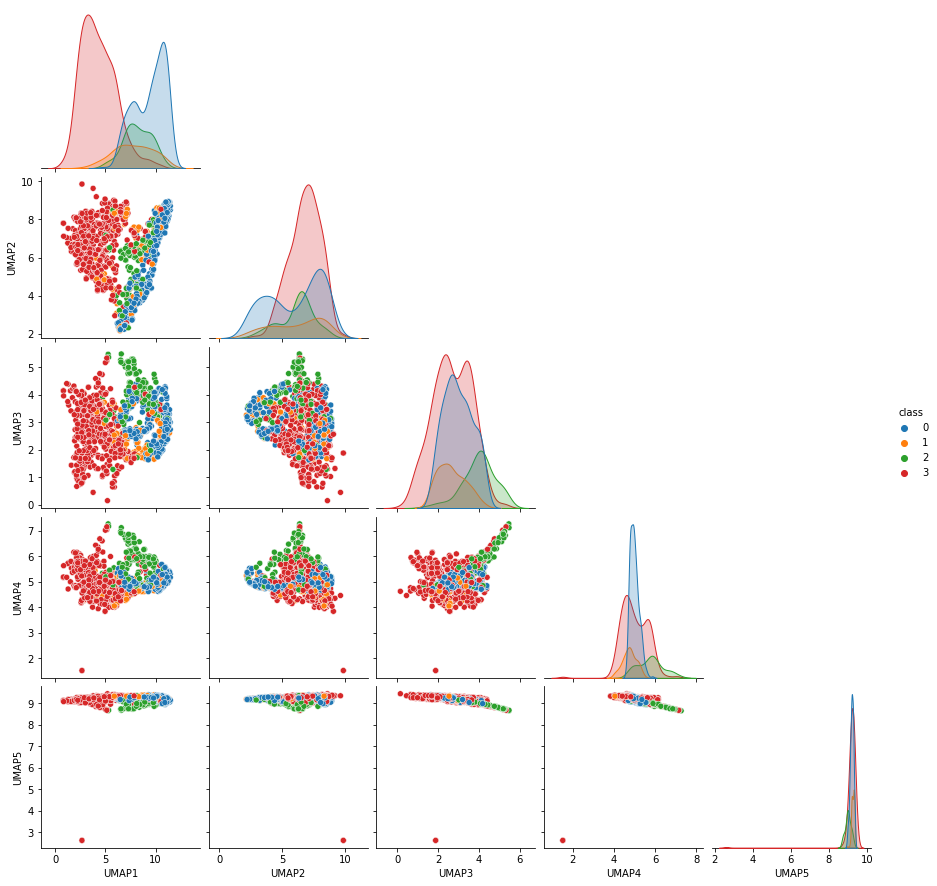

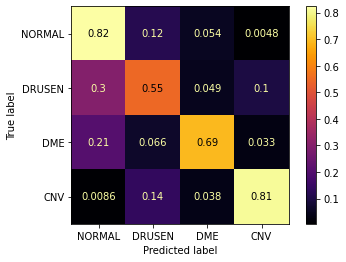

In [405]:
resnet_proj_UMAP = embedding_dimension_reduction(all_train_resnet_embed, 
                                                 all_train_labels.argmax(-1), 
                                                 method='UMAP', 
                                                 reduced_dimension=8, 
                                                 metric='euclidean')

# Label Spreading

- Assume we have an unsupervised model
- we use its embedding to construct psuedo-label by label smoothing
- the **uncertainty** of the label is quantified by the number of vote from independent runs

In [406]:
def masked_labels_embedding(full_embedding, 
                            full_labels, 
                            sample_per_class = 1, 
                            max_sample_per_class = 3000):
  """retain only n sample per each class, masked the rest with label == -1
  Args:
    sample_per_class:     n labeled images per class
    max_sample_per_class: number of total sample per class
  Returns:
    embeddings, labeles_masked, labels_truth
  """
  # order the labels by the unique class
  unique_class     = 4

  embeddings_ordered = []
  labels_ordered     = []
  labels_masked      = []
  index_ordered      = []

  full_index = np.arange(len(full_embedding))
  for i in range(unique_class):
    flags = (full_labels == i)

    index = full_index[flags][:max_sample_per_class]

    embeddings_ordered.append(full_embedding[index])
    labels_ordered.append(full_labels[index])


    idx = np.random.randint(0, max_sample_per_class,size=sample_per_class)
    ones = np.ones(max_sample_per_class, )*-1
    ones[idx] = i
    labels_masked.append(ones)

    index_ordered.append(index)

  labels_masked = np.hstack(labels_masked).astype(int)
  labels_ordered = np.hstack(labels_ordered).astype(int)
  embeddings_ordered = np.vstack(embeddings_ordered)

  return embeddings_ordered, labels_masked, labels_ordered, index_ordered

# repeat label spreading n times to get uncertain labels
def fit_labelSpreading(embedding, partial_labels):
  model_lb_spread = LabelSpreading(kernel='rbf', alpha=0.1,)
  model_lb_spread.fit(embedding, partial_labels )
  return model_lb_spread.transduction_

def run_labelSpreading(embedding, labels, sample_per_class = 1, max_sample_per_class = 4000, ntimes = 10):
  ground_truth     = []
  predicted_labels = []
  for k in range(ntimes):
    partial_embedding, partial_label, truth_label, index = masked_labels_embedding(embedding, 
                                                                    train_labels, 
                                                                    sample_per_class = sample_per_class, 
                                                                    max_sample_per_class = max_sample_per_class)
    pred_labels = fit_labelSpreading(partial_embedding, partial_label)

    predicted_labels.append(pred_labels)
    ground_truth.append(truth_label)

  labels_pred_stacked = np.vstack(predicted_labels)
  label_vote = []

  for l in range(4):
    label_vote.append( (labels_pred_stacked == l).sum(axis=0))
  label_vote = np.vstack(label_vote)

  return label_vote, pred_labels, ground_truth, index

In [407]:
train_labels = all_train_labels.argmax(-1)

In [409]:
all_votes = []

for i in [1, 5, 10, 30, 100]:
  label_vote, pred_labels, ground_truth, index_embeding = run_labelSpreading(resnet_proj_PCA, 
                                                                             train_labels,
                                                                             sample_per_class = i, 
                                                                             max_sample_per_class = 1000)
  all_votes.append(label_vote)

/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_supervised/_label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/usr/local/lib/python3.6/dist-packages/sklearn/semi_sup

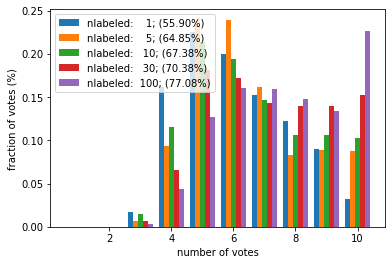

In [410]:
plt.hist(np.array(all_votes).max(1).transpose(), 
         bins=np.arange(0,11,1)+0.5, 
         density=True,
         label = [f"nlabeled: {c:4d}; ({sum(all_votes[i].argmax(0) == ground_truth[0]) / len(ground_truth[0])*100.:.2f}%)"  for i, c in enumerate([1, 5, 10, 30, 100])])
plt.xlabel('number of votes')
plt.ylabel('fraction of votes (%)')
plt.legend()

In [411]:
# goal here is given some index

def train_data_aug_single_image(img, lb):
  img = tf.image.resize(img, (128,128))
  img = tf.cast(img, tf.float32)/255.

  img = train_
  return img, tf.one_hot(lb, 4)

def resize_with_aug(img, lb):
  img = train_classification_aug(img, lb, img_size = 128)[0]
  return img, tf.one_hot(lb, 4)

def retrieve_embedding(index, batch_size=128):
  count = 0

  images = []
  labels = []

  index_test = index[:]

  counter = 1
  for X, y in ds_train.map(resize_only).batch(batch_size):

    current_batch_idx = index_test // (batch_size * counter)
    current_X_idx     = (index_test % batch_size)[current_batch_idx==0]
    
    images.append(X.numpy()[current_X_idx])
    labels.append(y.numpy()[current_X_idx].argmax(-1))

    # update the index_test to ignore batch that has been seen before
    index_test = index_test[current_batch_idx!=0]

    counter += 1
  return np.vstack(images), np.hstack(labels)

In [412]:
index_to_retrieve = np.vstack(index_embeding)
images, labels = retrieve_embedding(index_to_retrieve)

# select the most uncertain ones
- the images with most divided opinion among the runs
- i.e. the images with the least votes

In [413]:
def select_uncertain_images(votes, images, labels, min_vote = 5):

  vote_count = votes.max(0)

  img_selected = images[vote_count < min_vote]
  lb_selected  = labels[vote_count < min_vote]
  return img_selected, lb_selected

In [417]:
img_selected, lb_selected = select_uncertain_images(all_votes[0], 
                                                    images, 
                                                    labels, 
                                                    min_vote=5)

In [418]:
img_selected.shape

(714, 128, 128, 3)

In [419]:
np.bincount(lb_selected)

array([176, 167, 176, 195])

In [420]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2, 
    horizontal_flip=True)

In [421]:
a = lb_selected
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1

In [422]:
train_data_generator = datagen.flow(
    img_selected,
    y=b,
    batch_size=32,
    shuffle=True,
    seed=42,
    save_to_dir="uncertain",
    save_prefix="",
    save_format="png",
    )

In [423]:
X, y = next(iter(train_data_generator))

In [424]:
img_selected.shape

(714, 128, 128, 3)

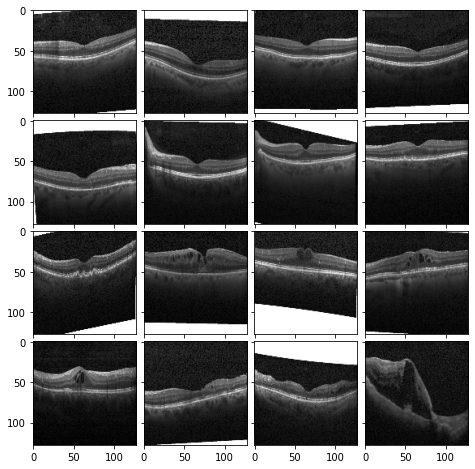

In [425]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(8., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, img_selected[:16]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [426]:
input_layer   = tf.keras.Input((128,128,3))
resnet_output = model_loadweights.layers[0](input_layer)
hidden        = tf.keras.layers.GlobalAveragePooling2D()(resnet_output)
output        = tf.keras.layers.Dense(4, activation='softmax')(hidden)

model_retrain = tf.keras.Model(input_layer, output)

In [427]:
model_retrain.layers[1].trainable = False

In [428]:
optimizer = tf.keras.optimizers.Adam(1e-3)

In [429]:
model_retrain.compile(loss = 'categorical_crossentropy', 
                      metrics=['accuracy'])

In [430]:
model_retrain.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet_1 (Resnet)            multiple                  11190464  
_________________________________________________________________
global_average_pooling2d_13  (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 2052      
Total params: 11,192,516
Trainable params: 2,052
Non-trainable params: 11,190,464
_________________________________________________________________


In [431]:
# ds_train_subsample, ds_train_info = tfds.load('RetinaDataset', split='train[:10%]', shuffle_files=False, as_supervised=True, with_info=True)
# ds_val_subsample,   ds_train_info = tfds.load('RetinaDataset', split='train[12%:13%]', shuffle_files=False, as_supervised=True, with_info=True)
# model_retrain.fit(ds_train_subsample.map(train_data_aug_single_image).batch(32),
#                   validation_data = ds_val_subsample.map(train_data_aug_single_image).batch(32), 
#                   epochs=10)
                  

In [432]:
history = model_retrain.fit(train_data_generator, 
                  validation_data = ds_val_subsample.map(resize_only).batch(32), 
                  epochs=20)

Epoch 1/20
23/23 [==============================] - 9s 312ms/step - loss: 1.1206 - accuracy: 0.5690 - val_loss: 0.7531 - val_accuracy: 0.8371
Epoch 2/20
23/23 [==============================] - 7s 290ms/step - loss: 0.7560 - accuracy: 0.7944 - val_loss: 0.5638 - val_accuracy: 0.8611
Epoch 3/20
23/23 [==============================] - 7s 304ms/step - loss: 0.5707 - accuracy: 0.8342 - val_loss: 0.4825 - val_accuracy: 0.8671
Epoch 4/20
23/23 [==============================] - 7s 299ms/step - loss: 0.5046 - accuracy: 0.8457 - val_loss: 0.4566 - val_accuracy: 0.8719
Epoch 5/20
23/23 [==============================] - 7s 292ms/step - loss: 0.4641 - accuracy: 0.8339 - val_loss: 0.3928 - val_accuracy: 0.8862
Epoch 6/20
23/23 [==============================] - 7s 307ms/step - loss: 0.4263 - accuracy: 0.8530 - val_loss: 0.3686 - val_accuracy: 0.8874
Epoch 7/20
23/23 [==============================] - 7s 296ms/step - loss: 0.3952 - accuracy: 0.8680 - val_loss: 0.3650 - val_accuracy: 0.8838
Epoch 

In [433]:
model_retrain.evaluate(ds_test.map(resize_only).batch(32))

31/31 [==============================] - 1s 21ms/step - loss: 0.1317 - accuracy: 0.9597


[0.13167621195316315, 0.9597107172012329]

# Finetune the classification model

In [434]:
model_retrain.layers[1].trainable = True

In [435]:
optimizer = tf.keras.optimizers.Adam(1e-5)

In [436]:
model_retrain.compile(loss = 'categorical_crossentropy', 
                      metrics=['accuracy'],
                      optimizer=optimizer)

In [437]:
history = model_retrain.fit(train_data_generator, 
                  validation_data = ds_val_subsample.map(resize_only).batch(32), 
                  epochs=20)

Epoch 1/20
23/23 [==============================] - 14s 376ms/step - loss: 0.3466 - accuracy: 0.8679 - val_loss: 0.3461 - val_accuracy: 0.8826
Epoch 2/20
23/23 [==============================] - 7s 309ms/step - loss: 0.2746 - accuracy: 0.9142 - val_loss: 0.3322 - val_accuracy: 0.8898
Epoch 3/20
23/23 [==============================] - 7s 304ms/step - loss: 0.3309 - accuracy: 0.8700 - val_loss: 0.3678 - val_accuracy: 0.8766
Epoch 4/20
23/23 [==============================] - 7s 307ms/step - loss: 0.2825 - accuracy: 0.8881 - val_loss: 0.3414 - val_accuracy: 0.8790
Epoch 5/20
23/23 [==============================] - 7s 310ms/step - loss: 0.3080 - accuracy: 0.8897 - val_loss: 0.3683 - val_accuracy: 0.8731
Epoch 6/20
23/23 [==============================] - 7s 312ms/step - loss: 0.3014 - accuracy: 0.8845 - val_loss: 0.3434 - val_accuracy: 0.8862
Epoch 7/20
23/23 [==============================] - 7s 309ms/step - loss: 0.3102 - accuracy: 0.8792 - val_loss: 0.3599 - val_accuracy: 0.8790
Epoch

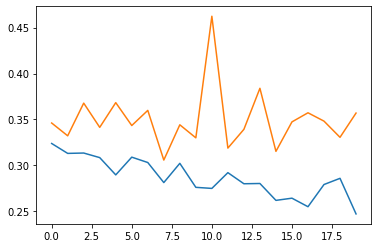

In [438]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [439]:
model_retrain.evaluate(ds_test.map(resize_only).batch(32))

31/31 [==============================] - 1s 21ms/step - loss: 0.1059 - accuracy: 0.9669


[0.10593082755804062, 0.9669421315193176]

# visualize the hidden embedding of the testset

In [440]:
model_retrain_representation = tf.keras.Sequential(layers=model_retrain.layers[:3])
model_retrain_representation.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_1 (Resnet)            multiple                  11190464  
_________________________________________________________________
global_average_pooling2d_13  (None, 512)               0         
Total params: 11,190,464
Trainable params: 11,180,736
Non-trainable params: 9,728
_________________________________________________________________


In [441]:
model_retrain_representation.compile()

In [442]:
resnet_finetuned_representation = [] 
for X in ds_test.map(resize_only).map(lambda img, lb: img).batch(32):
  resnet_finetuned_representation.append(model_retrain_representation(X, training=False).numpy())

resnet_finetuned_representation = np.vstack(resnet_finetuned_representation)

In [443]:
test_labels = np.vstack( [d.numpy()  for d in ds_test.map(lambda img, lb: tf.one_hot(lb,4)).batch(32)] )

In [444]:
resnet_finetuned_representation.shape

(968, 512)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       242
           1       0.99      0.96      0.97       242
           2       0.99      0.98      0.98       242
           3       0.98      0.99      0.99       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



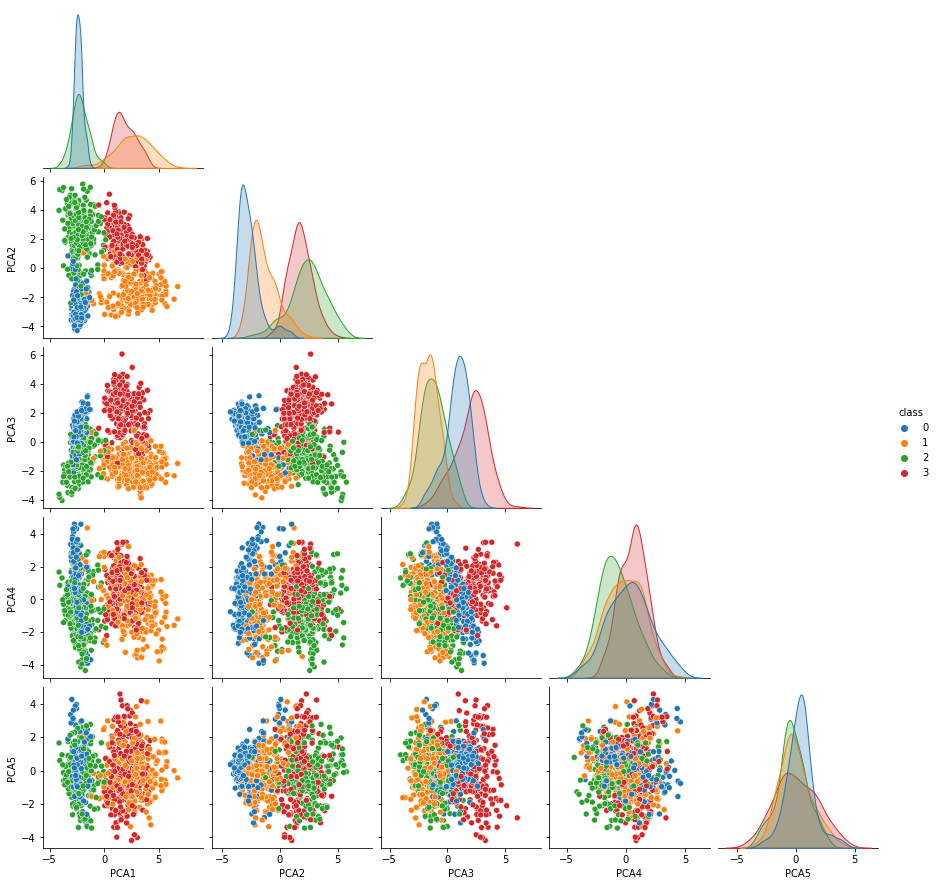

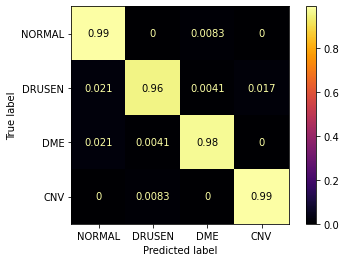

In [447]:
finetune_resnet_proj_PCA_test = embedding_dimension_reduction(resnet_finetuned_representation, 
                                                test_labels.argmax(-1), 
                                                method='PCA')

In [453]:
finetune_resnet_proj_PCA_test.shape

(968, 8)

In [455]:
df = pd.DataFrame()

In [456]:
df['PCA1'] = finetune_resnet_proj_PCA_test[:,0]
df['PCA2'] = finetune_resnet_proj_PCA_test[:,1]
df['PCA3'] = finetune_resnet_proj_PCA_test[:,2]

In [457]:
df['labels'] = test_labels.argmax(-1).astype(object)

In [459]:
import plotly.express as px

fig = px.scatter_3d(df, x='PCA1', y='PCA2', z='PCA3',
              color='labels')
fig.show()